In [0]:
# !pip uninstall tensorflow -y
# !pip install tensorflow

In [2]:
# Run this one if using google colab
from google.colab import drive
import sys
import os

drive.mount('/content/gdrive',True)
sys.path.append("/content/xray_code/python_code")

if not os.path.exists("/content/xray_code"):
  !cp -r "/content/gdrive/My Drive/xray_code/" "/content/xray_code"

Mounted at /content/gdrive


In [3]:
%load_ext autoreload
%autoreload 2

from utils import *
from ml_utils import XrayTF
from tqdm import tqdm_notebook as tqdm
from threading import Thread
from constants import LOCAL_IMAGES_LOCATION

import urllib.request as req
import matplotlib.pyplot as plt
import numpy as np
import time
import pprint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load csv if exist, if not get the original one and parse it


In [4]:
SICKNESS = "Effusion"
csv_file = "new_normalized_xray_without_full_path.csv"
csv_file_full_path = f'/content/gdrive/My Drive/xray_code/sheet/{csv_file}'

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCH = 100

# take existing if it exist
if os.path.exists(csv_file_full_path):
    df = pd.read_csv(csv_file_full_path)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
else:
    df = get_data_sheet()
    df = normalize_data_frame(df)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
    xray_class.df.to_csv(csv_file_full_path, index=False)

xray_class.df.head()

,Image Index,labels,View Position,Follow-up #,Patient ID,Patient Age,Patient Gender,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
0,https://images.marknavalta.com/v0.1/IM-0001-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://images.marknavalta.com/v0.1/IM-0003-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://images.marknavalta.com/v0.1/IM-0005-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://images.marknavalta.com/v0.1/IM-0006-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://images.marknavalta.com/v0.1/IM-0007-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analyze our data set
- take a look at the distribution
- prepare data before splitting to test and train
  - Get image based on xray Position
  - Select a sickness and balance them
- Generate Age histogram

In [5]:
print(xray_class.df["View Position"].value_counts())
print("="*50)
print(xray_class.df.labels.value_counts())

PA    87486
AP    59907
Name: View Position, dtype: int64
No Finding            61944
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumonia              5704
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Hernia                  227
Name: labels, dtype: int64


In [6]:
# Pick a sickness
xray_class.use_one_label(SICKNESS, balance=True)

# Verify how balanced our data is
print(xray_class.df.labels.value_counts())
print(xray_class.df["Patient Gender"].value_counts())

No Finding    13317
Effusion      13317
Name: labels, dtype: int64
M    14684
F    11602
Name: Patient Gender, dtype: int64


(0.0, 100.0)

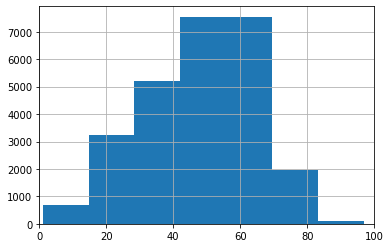

In [7]:
xray_class.df["Patient Age"].hist(bins=30).set_xlim(0,100)

# Download our data
- Parallel download from digital ocean
- prepend system path after download

In [8]:
!rm -rf /content/images
if not os.path.exists(LOCAL_IMAGES_LOCATION):
  !mkdir /content/images

  class Downloader(Thread):
    def __init__(self, file_url, save_path):
        Thread.__init__(self)
        self.file_url = file_url
        self.save_path = save_path

    def run(self):
        remaining_download_tries = 15

        while remaining_download_tries > 0:
            try:
                req.urlretrieve(self.file_url, self.save_path)
                time.sleep(0.1)
            except:
                print("error downloading " + self.file_url +
                      " on trial no: " + str(16 - remaining_download_tries))
                remaining_download_tries = remaining_download_tries - 1
                continue
            else:
                break
  # xray_class.df["Image Index"].apply(lambda x: Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ).start() )

  open_threads = [Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ) for x in xray_class.df["Image Index"]]
  started_threads = [thread.start() for thread in open_threads]
  joined_threads = [thread.join() for thread in open_threads]

  del open_threads
  del started_threads
  del joined_threads

error downloading https://images.marknavalta.com/v0.1/00013648_025.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00002775_006.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00018680_015.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00022281_000.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00009638_021.png on trial no: 1error downloading https://images.marknavalta.com/v0.1/00026818_036.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00014125_016.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00002351_004.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00011720_000.png on trial no: 1
error downloading https://images.marknavalta.com/v0.1/00015009_011.png on trial no: 1error downloading https://images.marknavalta.com/v0.1/00020476_003.png on trial no: 1

error downloading https://images.marknavalta.com/v0.1/0

In [9]:
#  let's now append the full system path
xray_class.df["Image Index"] = xray_class.df["Image Index"].apply(lambda x : LOCAL_IMAGES_LOCATION + x.split('/')[-1])
xray_class.df.head()

,Image Index,labels,View Position,Follow-up #,Patient ID,Patient Age,Patient Gender,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
78169,/content/images/00021996_011.png,No Finding,AP,11.0,21996.0,68.0,M,3056.0,2544.0,0.139000,0.139000
54376,/content/images/00014465_018.png,No Finding,AP,18.0,14465.0,65.0,M,2500.0,2048.0,0.168000,0.168000
75104,/content/images/00020912_006.png,No Finding,AP,6.0,20912.0,43.0,M,3056.0,2544.0,0.139000,0.139000
90665,/content/images/00027734_000.png,No Finding,PA,0.0,27734.0,30.0,F,2021.0,2021.0,0.194311,0.194311
9127,/content/images/00001075_030.png,No Finding,AP,30.0,1075.0,59.0,F,3056.0,2544.0,0.139000,0.139000


# Pre-processing of images and label
- split dataframe accordingly with equal numbers of labels in test and train
- batches image
- show image

In [10]:
# Split them into training and validation using NUM_IMAGES 
train_df, valid_df, test_df = xray_class.get_test_train_split_data(len(xray_class.df))

print(train_df.labels.value_counts())
print("="*50)
print(valid_df.labels.value_counts())
print("="*50)
print(test_df.labels.value_counts())


No Finding    10654
Effusion      10653
Name: labels, dtype: int64
Effusion      2137
No Finding    2124
Name: labels, dtype: int64
No Finding    539
Effusion      527
Name: labels, dtype: int64


In [11]:
# Create training and validation data batches using ImageDataGenerator
train_data = xray_class.generate_image(train_df, True)
val_data   = xray_class.generate_image(valid_df)
test_data   = xray_class.generate_image(test_df)

Found 21307 validated image filenames belonging to 2 classes.
Found 4261 validated image filenames belonging to 2 classes.
Found 1066 validated image filenames belonging to 2 classes.


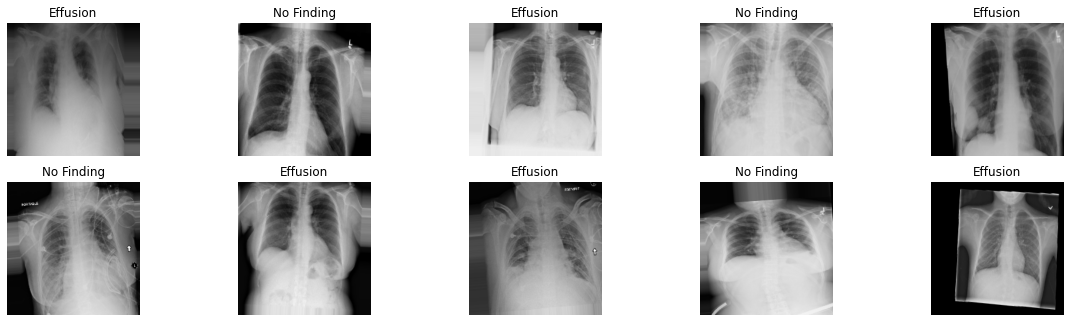

In [12]:
train_images, train_labels = next(train_data)
xray_class.show_25_images(train_images, train_labels)

# Perform model trainining
- fit our data using Categorical classification with metrics of accuracy and optimization Adam
- validate data
- save our model

In [0]:
result = xray_class.cross_validation(EPOCH, train_data, val_data, test_data)

666/666 [==============================] - 569s 854ms/step - loss: 0.5794 - accuracy: 0.7197 - val_loss: 0.5080 - val_accuracy: 0.7639
Epoch 3/100
666/666 [==============================] - 569s 855ms/step - loss: 0.5372 - accuracy: 0.7381 - val_loss: 0.5012 - val_accuracy: 0.7646
Epoch 4/100
666/666 [==============================] - 567s 851ms/step - loss: 0.5282 - accuracy: 0.7460 - val_loss: 0.5044 - val_accuracy: 0.7670
Epoch 5/100
666/666 [==============================] - 568s 853ms/step - loss: 0.5249 - accuracy: 0.7514 - val_loss: 0.4966 - val_accuracy: 0.7672
Epoch 6/100
666/666 [==============================] - 568s 853ms/step - loss: 0.5189 - accuracy: 0.7541 - val_loss: 0.5172 - val_accuracy: 0.7623
Epoch 7/100
666/666 [==============================] - 565s 848ms/step - loss: 0.5191 - accuracy: 0.7514 - val_loss: 0.5040 - val_accuracy: 0.7630
Epoch 8/100
666/666 [==============================] - 569s 854ms/step - loss: 0.5170 - accuracy: 0.7570 - val_loss: 0.5137 - val_

  ...
    to  
  ['...']


34/34 [==============================] - 15s 456ms/step - loss: 0.5219 - accuracy: 0.7598
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_12 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Train

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 666 steps, validate for 134 steps
Epoch 1/100
666/666 [==============================] - 581s 872ms/step - loss: 0.7577 - accuracy: 0.6421 - val_loss: 0.5846 - val_accuracy: 0.7332
Epoch 2/100
666/666 [==============================] - 566s 850ms/step - loss: 0.6146 - accuracy: 0.6770 - val_loss: 0.5588 - val_accuracy: 0.7261
Epoch 3/100
666/666 [==============================] - 570s 855ms/step - loss: 0.6313 - accuracy: 0.6548 - val_loss: 0.5960 - val_accuracy: 0.7435
Epoch 4/100
666/666 [==============================] - 573s 861ms/step - loss: 0.6367 - accuracy: 0.6492 - val_loss: 0.5997 - val_accuracy: 0.6963
Epoch 5/100
666/666 [==============================] - 570s 856ms/step - loss: 0.6432 - accuracy: 0.6477 - val_loss: 0.6028 - val_accuracy: 0.6954
Epoch 6/100
666/666 [==============================] - 566s 851ms/step - loss: 0.6606 - accuracy: 0.6253 - val_loss: 0.6474 - val_accuracy: 0.6524
  ...
    to  
  ['...']


  ...
    to  
  ['...']


34/34 [==============================] - 16s 460ms/step - loss: 0.6558 - accuracy: 0.6295
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_15 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Train

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 666 steps, validate for 134 steps
Epoch 1/100
666/666 [==============================] - 586s 880ms/step - loss: 0.6348 - accuracy: 0.6733 - val_loss: 0.5797 - val_accuracy: 0.7463
Epoch 2/100
666/666 [==============================] - 575s 863ms/step - loss: 0.5773 - accuracy: 0.7096 - val_loss: 0.5436 - val_accuracy: 0.7529
Epoch 3/100
666/666 [==============================] - 573s 861ms/step - loss: 0.5566 - accuracy: 0.7280 - val_loss: 0.5321 - val_accuracy: 0.7587
Epoch 4/100
666/666 [==============================] - 572s 859ms/step - loss: 0.5467 - accuracy: 0.7363 - val_loss: 0.5408 - val_accuracy: 0.7590
Epoch 5/100
666/666 [==============================] - 571s 858ms/step - loss: 0.5431 - accuracy: 0.7396 - val_loss: 0.5478 - val_accuracy: 0.7634
Epoch 6/100
666/666 [==============================] - 574s 862ms/step - loss: 0.5379 - accuracy: 0.7438 - val_loss: 0.5366 - val_accuracy: 0.7580
Epoch 7/100
666/666 [==============================] - 575s 863ms/step - l

  ...
    to  
  ['...']


34/34 [==============================] - 16s 464ms/step - loss: 0.5418 - accuracy: 0.7711
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_18 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Train

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 666 steps, validate for 134 steps
Epoch 1/100
666/666 [==============================] - 583s 876ms/step - loss: 0.6606 - accuracy: 0.6603 - val_loss: 0.5620 - val_accuracy: 0.7153
Epoch 2/100
666/666 [==============================] - 568s 852ms/step - loss: 0.5797 - accuracy: 0.7059 - val_loss: 0.5475 - val_accuracy: 0.7566
Epoch 3/100
665/666 [============================>.] - ETA: 0s - loss: 0.5620 - accuracy: 0.7228

In [0]:
pprint.pprint(result[max(result, key=float)])

model = result[max(result, key=float)]["model"]
a, b = model.evaluate(test_data)

filename= f"{SICKNESS}_{b:.2f}"
xray_class.save_model(model, filename)

In [0]:
if xray_class.model_exist(SICKNESS):
    model = xray_class.model_exist(SICKNESS)
    a, b = model.evaluate(test_data)
else:
    model, stop = xray_class.train_model(EPOCH, train_data, val_data)
    a, b = model.evaluate(test_data)

    filename= f"{SICKNESS}_{b:.2f}"
    xray_class.save_model(model, filename)

In [0]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs_range = range(stop.stopped_epoch + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Post processing
- Predict our validation data
- load tensorboard
- Show images and percentage of accuracy for those prediction

In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_data, verbose=1)

In [0]:
# Let's check a few predictions and their different values
test_images, test_labels = next(test_data)

i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  xray_class.plot_pred(prediction_probabilities=predictions,
            labels=test_labels,
            images=test_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  xray_class.plot_pred_conf(prediction_probabilities=predictions,
                labels=test_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Evaluating our model
- confusion matrix
- classification report
- loss and accuracy

In [0]:
print(f"Loss : {a}, Accuracy: {b}")

In [0]:
# y_test = [xray_class.get_label(x) for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
# y_val = [xray_class.get_unique_labels()[x] for x in test_data.labels]
y_test = [test_df.labels.unique()[np.argmax(x)] for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
y_val = [test_df.labels.unique()[x] for x in test_data.labels]

xray_class.generate_confusion_matrix(y_test, y_val)

In [0]:
xray_class.generate_classification_report(y_test, y_val)